# Wavelet development

This is my recipe cookbook notebook for wavelet analysis. There are two major things that I want to test out and demonstrate:

1) Rectifiying the spectra and biwavelet cross-spectra to conserve energy. The rectification follows L07 and V12 and inhibits the explosion of the spectra at larger scales, enabling the diagnosis of smaller scale features.

2) Developing helper functions to simplify the wavelet analysis. All examples e.g. for pycwt require fairly beefy amounts of code that have to repeated for each analysis. A helper function enables simple iteration in future work.

Additionally, each general approach will be compared to examples in literature to verify that the pycwt library and my additions to it all function in a consistent way.


In [1]:
# math stuff
import numpy as np
import pycwt as wavelet

# OS interaction
import sys
# Add the other files from these helper functions
sys.path.append('../helper_functions')
sys.path.append('../figures')

# import plotting|
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pycwt.helpers import find
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import ticker
from matplotlib import colors

# Local pycwt helper functions
import pycwt_stat_helpers as cwt_stat
import pycwt_plot_helpers as cwt_plt
import SRON

# Format plots

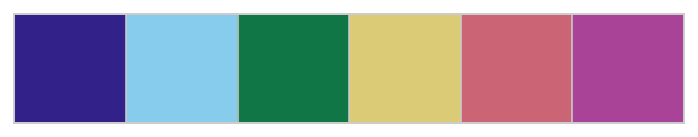

In [2]:
%matplotlib inline
# Higher resolution figures within the notebook
%config InlineBackend.figure_format = 'retina'

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context("paper")

# Define a default color palette (this should be fairly color blind friendly)
flatui = SRON.SRON(6)
sns.set_palette(sns.color_palette(flatui))
sns.palplot(sns.color_palette(flatui))

# Test data (from Liu et al., 2007)

In this test I demonstrate the utility of rectification and recreate the plots from L07 for consistency checking.

The synthetic signal has 5 superimposed oscillators with identical amplitudes. Note that I have substantially shortened the synthetic dataset relative to L07 to reduce the computational cost.

### First, without rectification

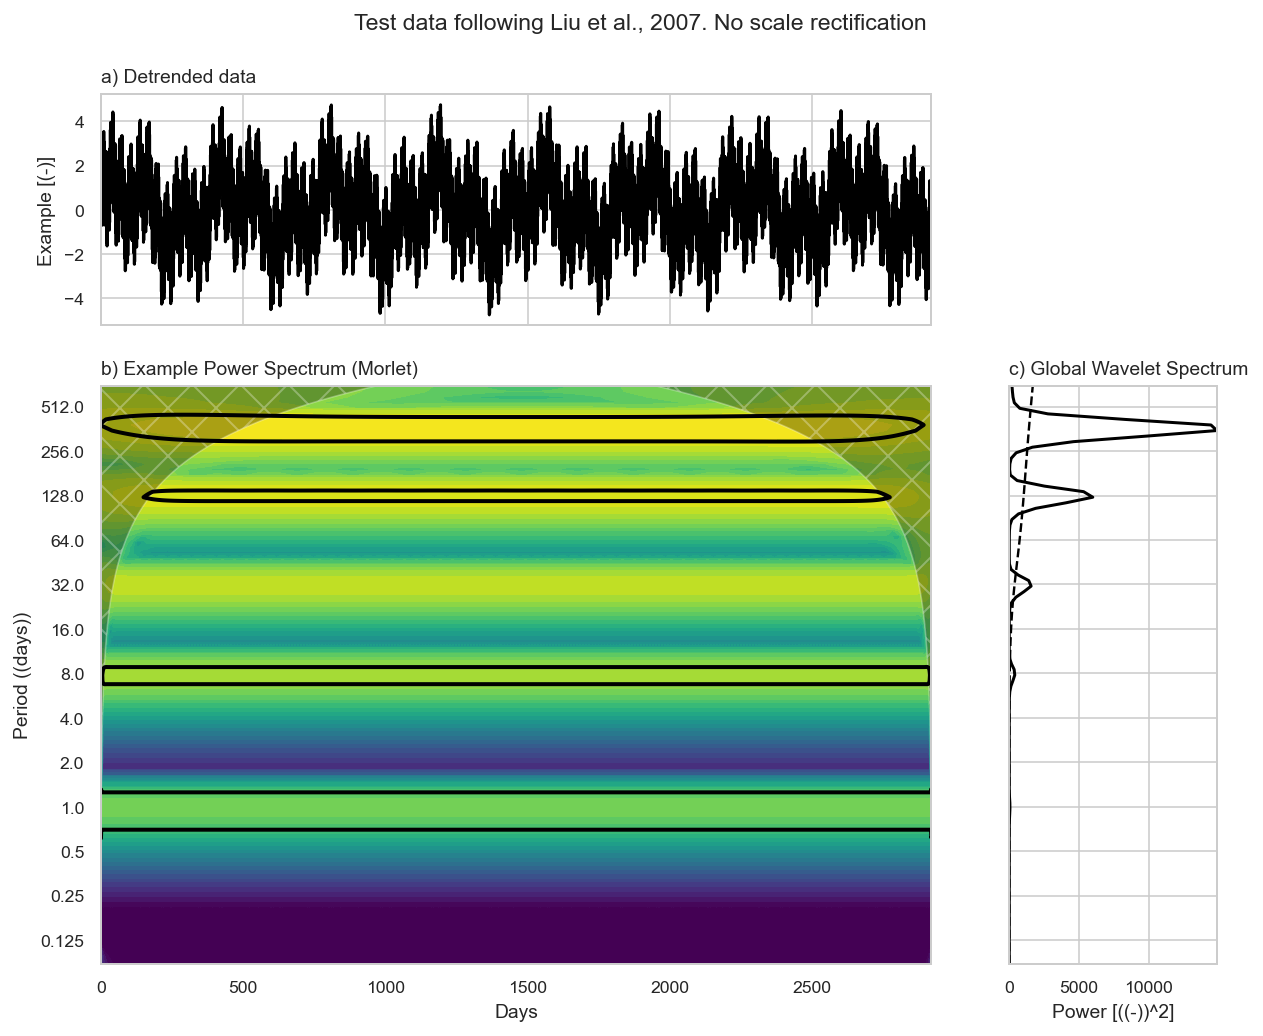

In [3]:
periods_days = np.array([1, 8, 32, 128, 365]) / 24
hours = np.arange(0, 8 * 365, 1 / 24)
signal = np.zeros_like(hours)
for p in periods_days:
    signal = signal + np.sin(hours * 2 * np.pi / (24 * p))

N = signal.size
mother = wavelet.Morlet()
# Twelve sub-octaves per octaves
# Nine powers of two with dj sub-octaves
octaves = [1 / 8, 13 / (1 / 8)]  

# Perform the CWT
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, 1/24, hours, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=False,
    norm_kwargs={'standardize': False, 'detrend': False}
)

# Create the periodogram
title = 'Test data following Liu et al., 2007. No scale rectification'
label = 'Example'
units = '(-)'
scale_units = '(days)'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': 'Days'
}

cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=1/24,
    period=period,
    power=power,
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power,
    sig95=sig95,
    scale_avg=scale_avg,
    scale_avg_signif=scale_avg_signif,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

Here the problem is quite clear. Even though all of the oscillators have an identical amplitude, the largest scales have the largest spectra peaks.

### Now with rectification

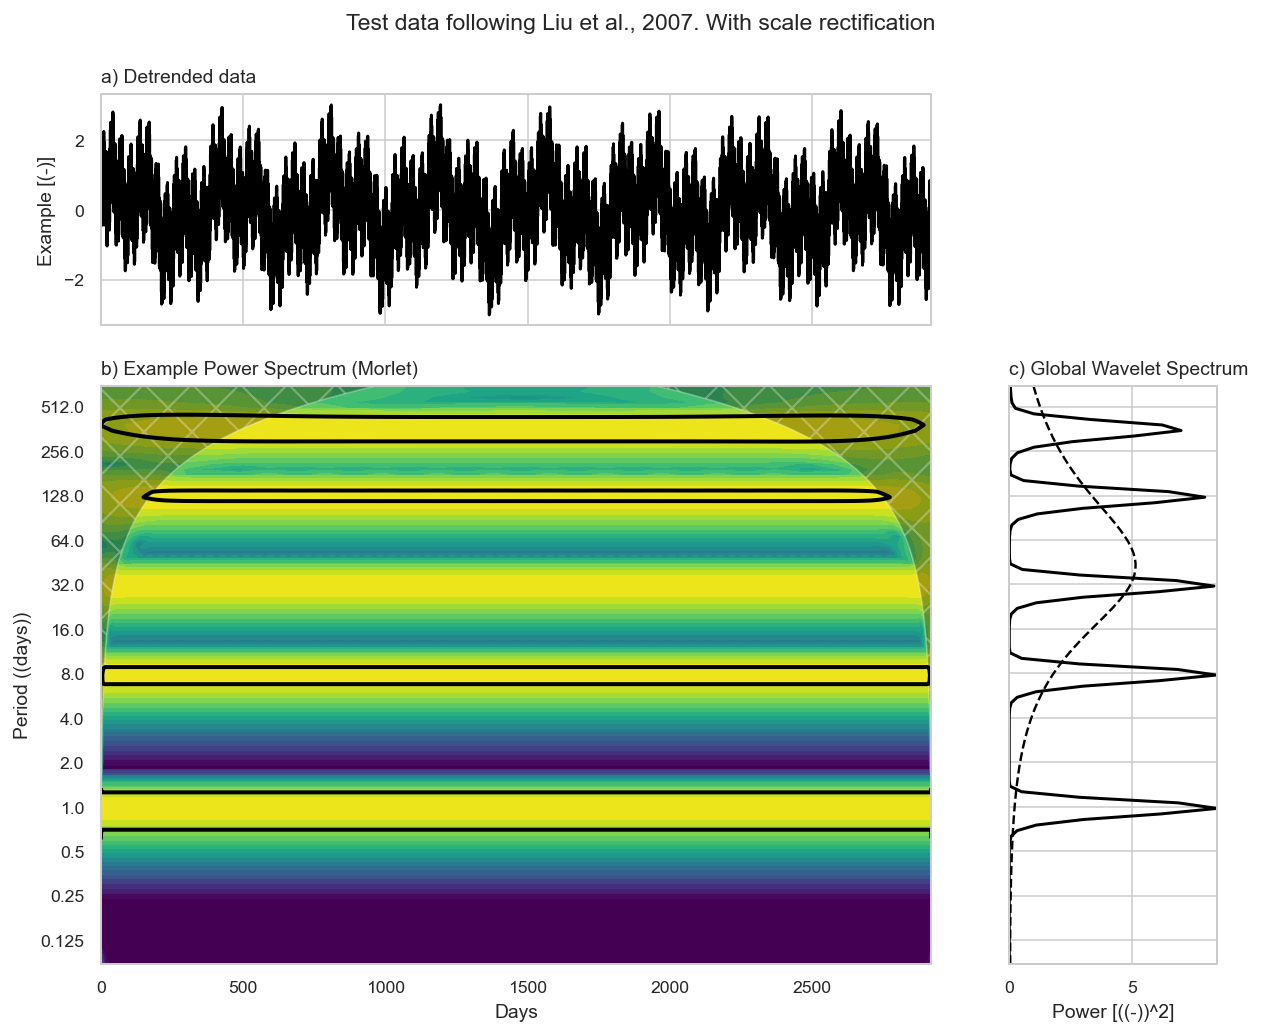

In [4]:
periods_days = np.array([1, 8, 32, 128, 365]) / 24
hours = np.arange(0, 8 * 365, 1 / 24)
signal = np.zeros_like(hours)
for p in periods_days:
    signal = signal + np.sin(hours * 2 * np.pi / (24 * p))

N = signal.size
mother = wavelet.Morlet()
# Twelve sub-octaves per octaves
# Nine powers of two with dj sub-octaves
octaves = [1 / 8, 13 / (1 / 8)]  

# Perform the CWT (note that rectify=True is the default)
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal, 1/24, hours, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=True,
    rectify=True,
    norm_kwargs={'standardize': True, 'detrend': False},
)

# Create the periodogram
title = 'Test data following Liu et al., 2007. With scale rectification'
label = 'Example'
units = '(-)'
scale_units = '(days)'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None,
    'xlabel': 'Days'
}

cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=1/24,
    period=period,
    power=power,
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power,
    sig95=sig95,
    scale_avg=scale_avg,
    scale_avg_signif=scale_avg_signif,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

For reference, here is the equivalent plot from L07.

<img src='../figures/Liu2007_Fig2.png' width="600" height="600">

and here is a related plot that looks at just the global (time averaged) wavelet spectra:

<img src='../figures/Liu2007_Fig3.png' width="600" height="600">

I cannot convincingly resolve the difference in the global power between my tests and L07. However, I am skeptical that it is even possible as Figures 2 and 3 give inconsistent results (above).

Figure 2 gives peaks in the time-averaged rectified wavelet spectra of a bit greater than 5. I can approximately recreate that by turning off standardization and scaling the global power by the variance.

Figure 3 gives peaks for _the same quantity_ around ~40. I can approxiamtely recreate peaks of this size by turning on standardization and scaling the global power by the variance.

My suspicion is that everyone is using similar code to generating these kinds of periodograms. The code automatically adjusts the globally-averaged wavelet spectra to be in log2 space (compare Fig 2 and 3e). I suspect a similar process is at play in the below plots. I cannot exactly resolve these differences, however. While it is frustrating that I cannot resolve the small differences, I must move on.

### __pycwt, the rectification, and my helper functions behave as expected for the CWT.__

# Wavelet Linear Coherence and rectified cross-wavelet transforms

Next we look at the Wavelet Linear Coherence (COH) and the Cross-Wavelet Transform (XWT). For this test we employ the V12 toy data.

There are two signals that have operate at resonant frequencies to each other. Both signals share an oscillatory frequency with a larger amplitude than the others. One of the signals has an additional frequency with an enhanced frequency.

### First, the individual signals

The CWT is scale rectified. Standardizing is on in the `norm_kwargs`. This is the default decision as it means that the CWT operates on data that has a variance of 1, meaning no further scaling is necessary. However, this decision is "controversial" in the sense that standardizing appears to be selectively applied to the global spectra, as above, and will be shown again below.

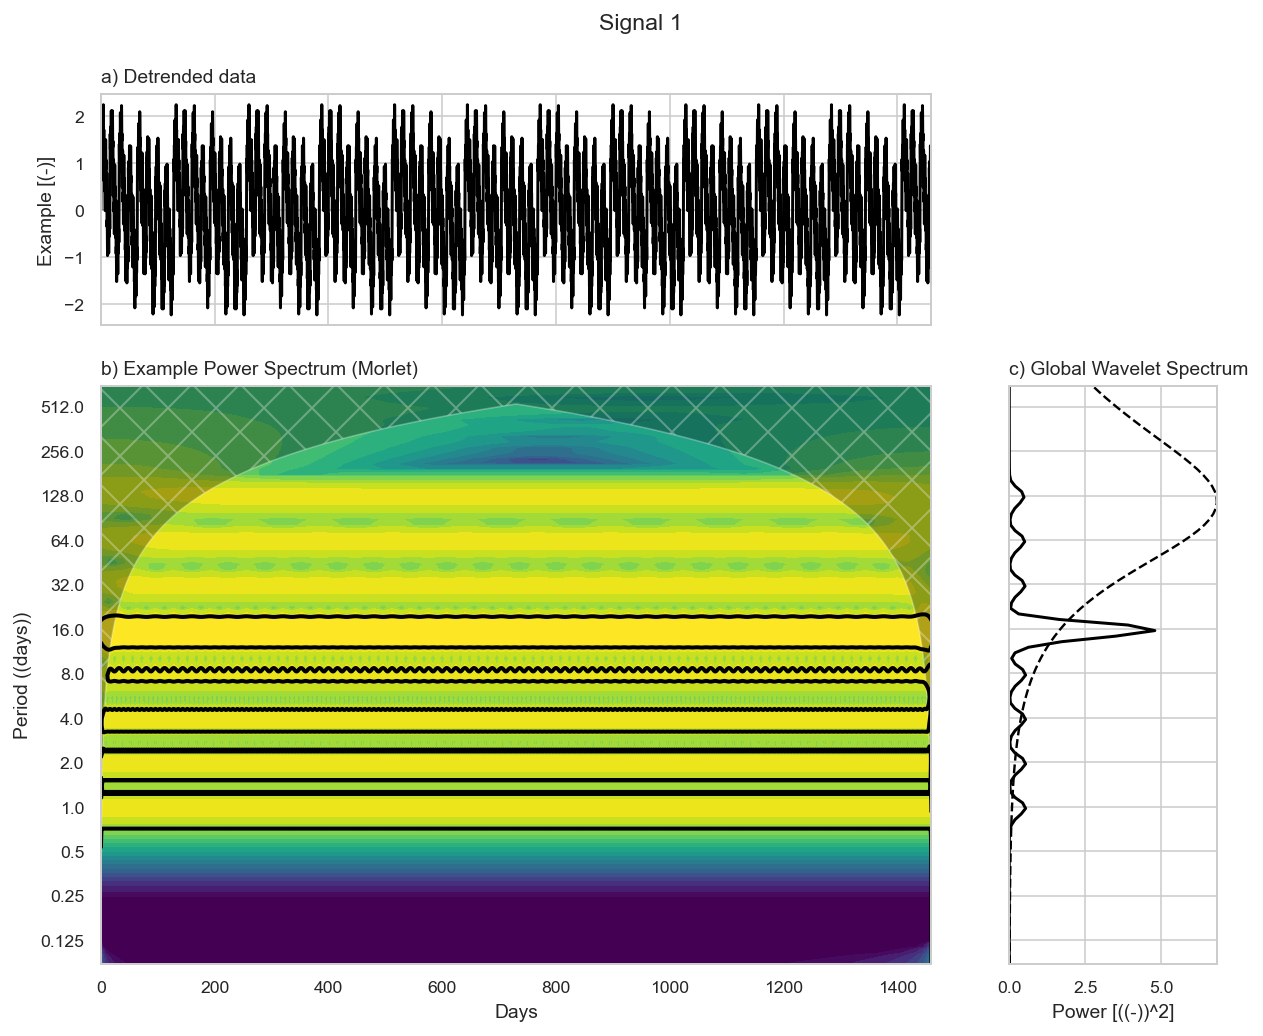

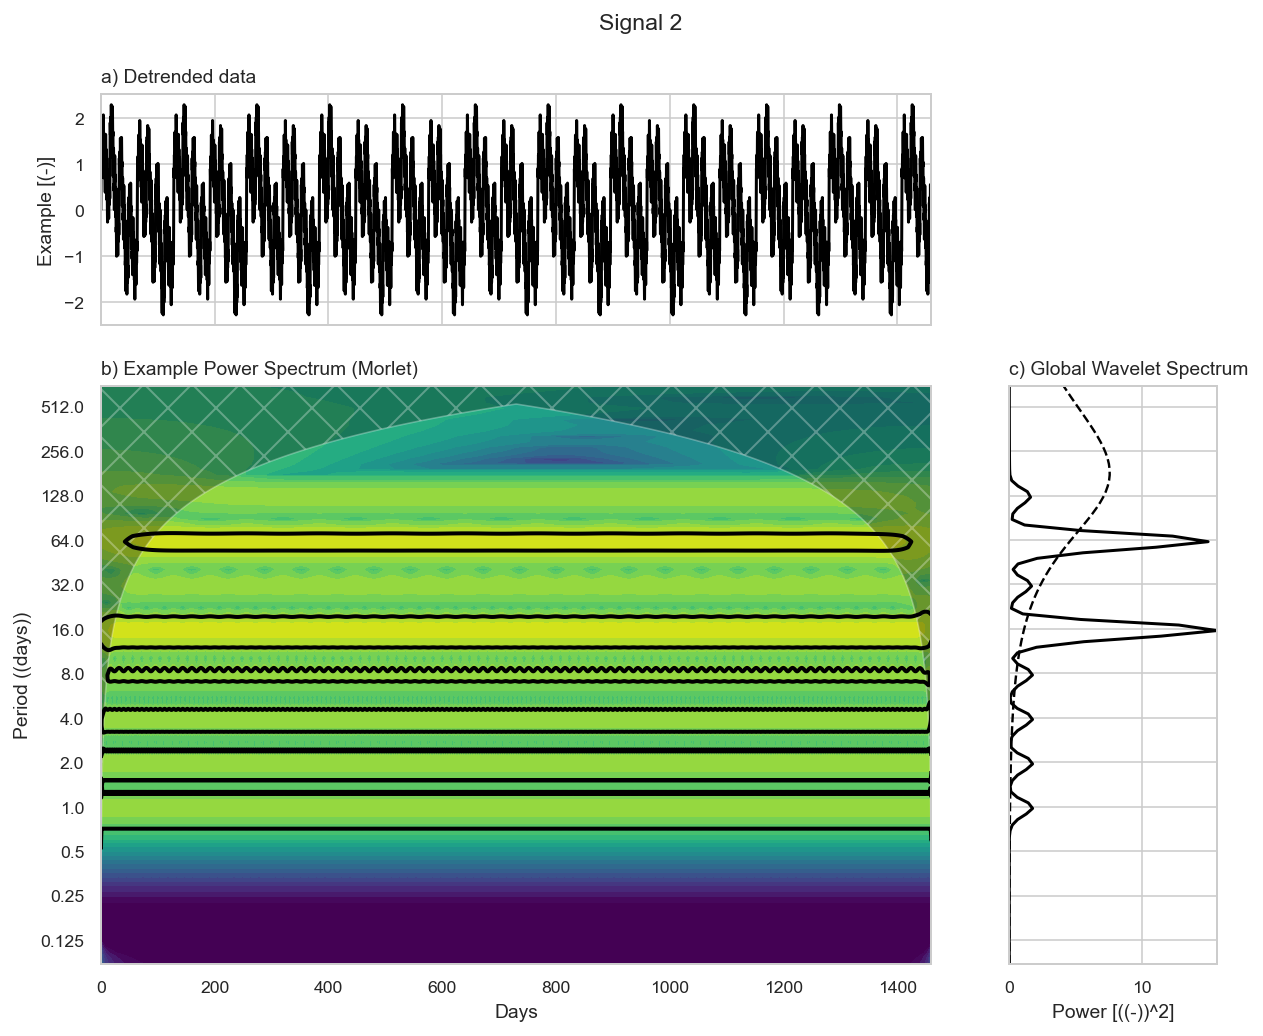

In [5]:
# Build the synthetic data
dx = 1 / 24

periods_days = np.array([1, 2, 4, 8, 16, 32, 64, 128]) / 24
hours = np.arange(0, 365 * 4, 1 / 24)

amplitudes1 = np.array([1, 1, 1, 1, 3, 1, 1, 1, 1])
signal1 = np.zeros_like(hours)
for pnum, p in enumerate(periods_days):
    signal1 = signal1 + np.sin(hours * 2 * np.pi / (24 * p)) * amplitudes1[pnum]

signal2 = np.zeros_like(hours)
amplitudes2 = np.array([1, 1, 1, 1, 3, 1, 3, 1])
for pnum, p in enumerate(periods_days):
    signal2 = signal2 + np.sin(hours * 2 * np.pi / (24 * p)) * amplitudes2[pnum]

# Wavelet arguments
N = signal1.size
mother = wavelet.Morlet()
# Twelve sub-octaves per octaves
# Nine powers of two with dj sub-octaves
octaves = [1 / 8, 13 / (1 / 8)]  

# Periodogram arguments
title = 'Test data following Veleda et al., 2012'
label = 'Example'
units = '(-)'
scale_units = '(days)'

fig_labels = {
    'title': title,
    'label': label,
    'units': units,
    'scale_units': scale_units,
    'mother': 'Morlet',
    'avg_scales': None, 
    'xlabel': 'Days'
}

# CWT signal 1
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal1, dx, hours, mother, 
    octaves=octaves,
    scales_to_avg=None,
    glbl_power_var_scaling=False,
    norm_kwargs={'standardize': True, 'detrend': False}
)

fig_labels['title'] = 'Signal 1'
cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=dx,
    period=period,
    power=power * np.sqrt(dx),
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power * np.sqrt(dx),
    sig95=sig95,
    scale_avg=scale_avg,
    scale_avg_signif=scale_avg_signif,
    fig_labels=fig_labels,
    include_colorbar=False)

# CWT signal 2
(signal_norm, period, coi,
 power, glbl_signif, glbl_power,
 sig95, scale_avg, scale_avg_signif, scales) = cwt_stat.wavelet_power(
    signal2, dx, hours, mother, 
    octaves=octaves, scales_to_avg=None,
    glbl_power_var_scaling=False,
    norm_kwargs={'standardize': True, 'detrend': False}
)

fig_labels['title'] = 'Signal 2'
cwt_plt.plot_wv_power(
    signal_norm=signal_norm,
    x=hours,
    dx=dx,
    period=period,
    power=power,
    coi=coi,
    glbl_signif=glbl_signif,
    glbl_power=glbl_power,
    sig95=sig95,
    fig_labels=fig_labels,
    include_colorbar=False
)

For reference, here are the equivalent figures from V12

__signal 1__

<img src='../figures/veleda2012_Fig1.png' width="600" height="600">


__signal 2__

<img src='../figures/veleda2012_Fig2.png' width="600" height="600">


### Scaling the power

There are some annoying inconsistencies here, which makes testing the toy dataset difficult. If I turn off standardizing I get a time series with amplitude between [-5, 5] (consistent with Figure 2). But that yields a larger global wavelet spectrum (~40 for the peaks) as opposed to the values of 15 we see above and the values of ~4 that they plot in their figures. There are some other factors that make me skeptical, such as inconsistent axis units.

However! After a bunch of detective work, I think that these globally-averaged power spectra are in `log2` and not linear. I demonstrate that below.

Text(0.5, 0, 'Period (days)')

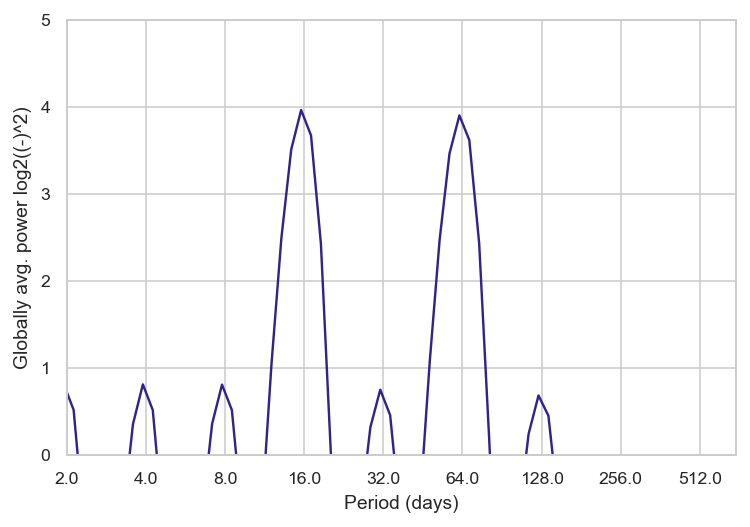

In [6]:
# Plot the globally averaged power in log2 space

plt.plot(np.log2(period), np.log2(glbl_power))
ax = plt.gca()
ax.set_ylim(0, 5)

Yticks = 2 ** np.arange(
    np.ceil(np.log2(period.min())),
    np.ceil(np.log2(period.max())))

ax.set_xticks(np.log2(Yticks))
ax.set_xticklabels(Yticks)
plt.setp(ax.get_xticklabels(), visible=True)
ax.set_xlim(np.log2([2, period.max()]))
ax.set_ylabel('Globally avg. power log2((-)^2)')
ax.set_xlabel('Period (days)')

That is the closest I have come to reproducing the results from this paper. These peaks are slightly larger than those in the paper, but I think that's explainable through small variations in the wavelet implementation (e.g., they don't state the wavelet parameters and I don't know what code they are implmenting). The best part of this is that the relative peak sizes is similar to the published method.

### Inconsistent significance/non-stationarity tests

In my version of the plots above, I've included signficance testing. Here, the data are tested against an AR(1) process determined by operating on the input signals. Since these data does not have any lag built in, the AR(1) null hypothesis should be negligible and indicate that signal frequencies are significant. Instead, those are treated as "not significant". These definitions and usage will be explored below.

# Cross-wavelet Transform (XWT)

Here the rectification from V12 will be employed.

In [7]:
(WCT, aWCT, W12,
 W12_corr, period,
 coi, angle, s1, s2) = cwt_stat.wavelet_coherent(
    signal1,
    signal2,
    dx,
    octaves[0],
    2 * dx,
    octaves[1],
    mother,
    norm_kwargs={'standardize': True, 'detrend': False}
)

# Cross wavelet spectra
fig_labels = {
    'title': 'Replication of Veleda et al. test case',
    'label': 'Synthetic Data',
    'units': '-',
    'scale_units': 'days',
    'mother': mother.name,
    'avg_scales': 'None',
    'xlabel': 'Days'
}


### First, without scale rectification

No handles with labels found to put in legend.


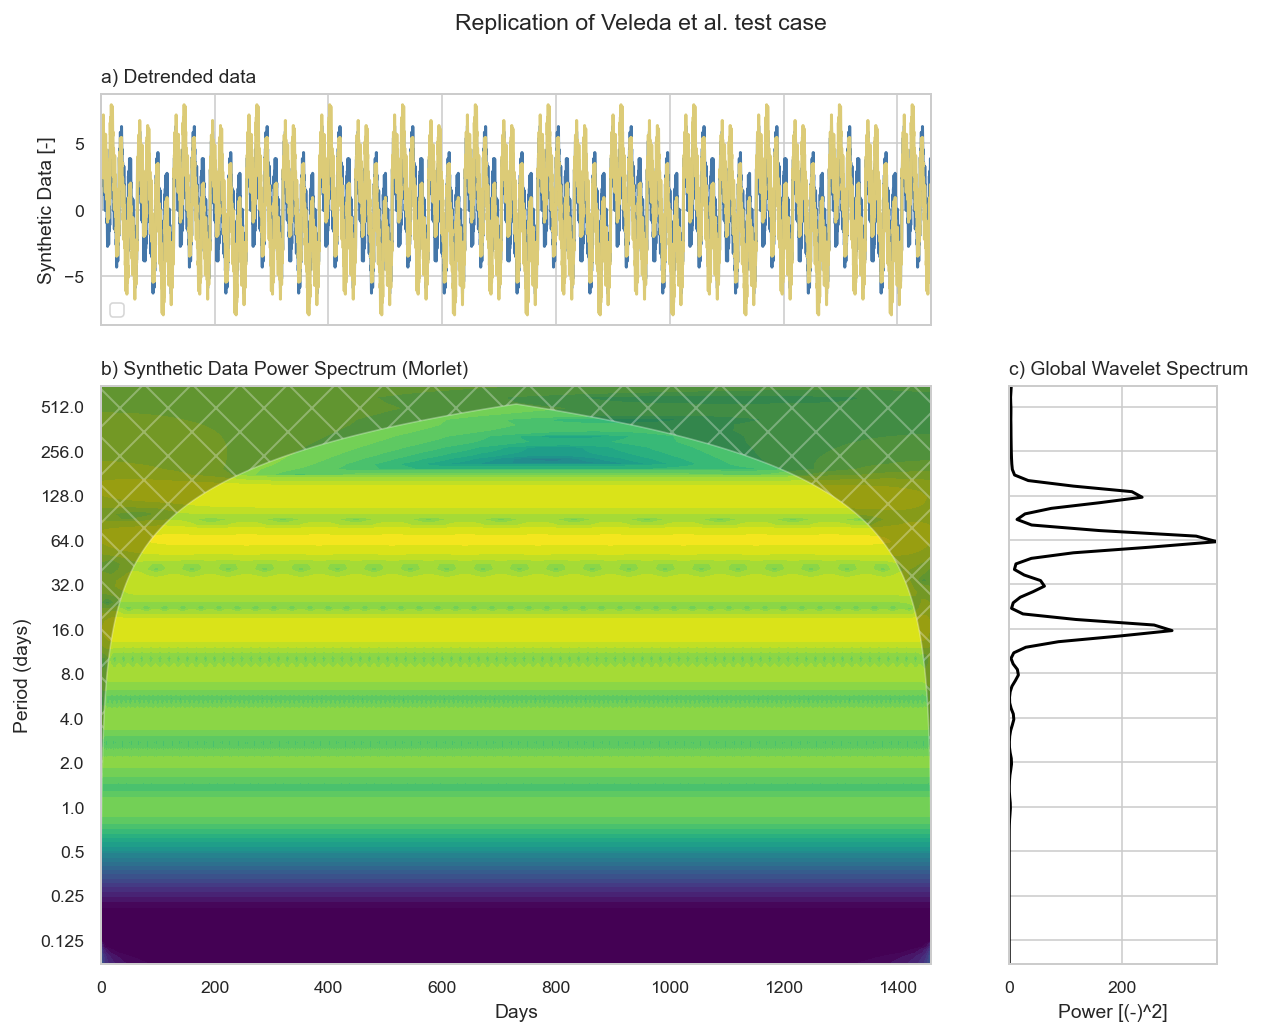

In [8]:
# Power is NOT squared since it is already the product of
# two wavelet spectra. Instead, we just take the absolute value
# of the complex values.

cwt_plt.plot_wv_power(
    signal_norm=[signal1, signal2],
    x=hours,
    dx=dx,
    period=period,
    power=np.abs(W12),
    coi=coi,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

### And then with scale rectification

Note that both variables are returned by the helper function.

No handles with labels found to put in legend.


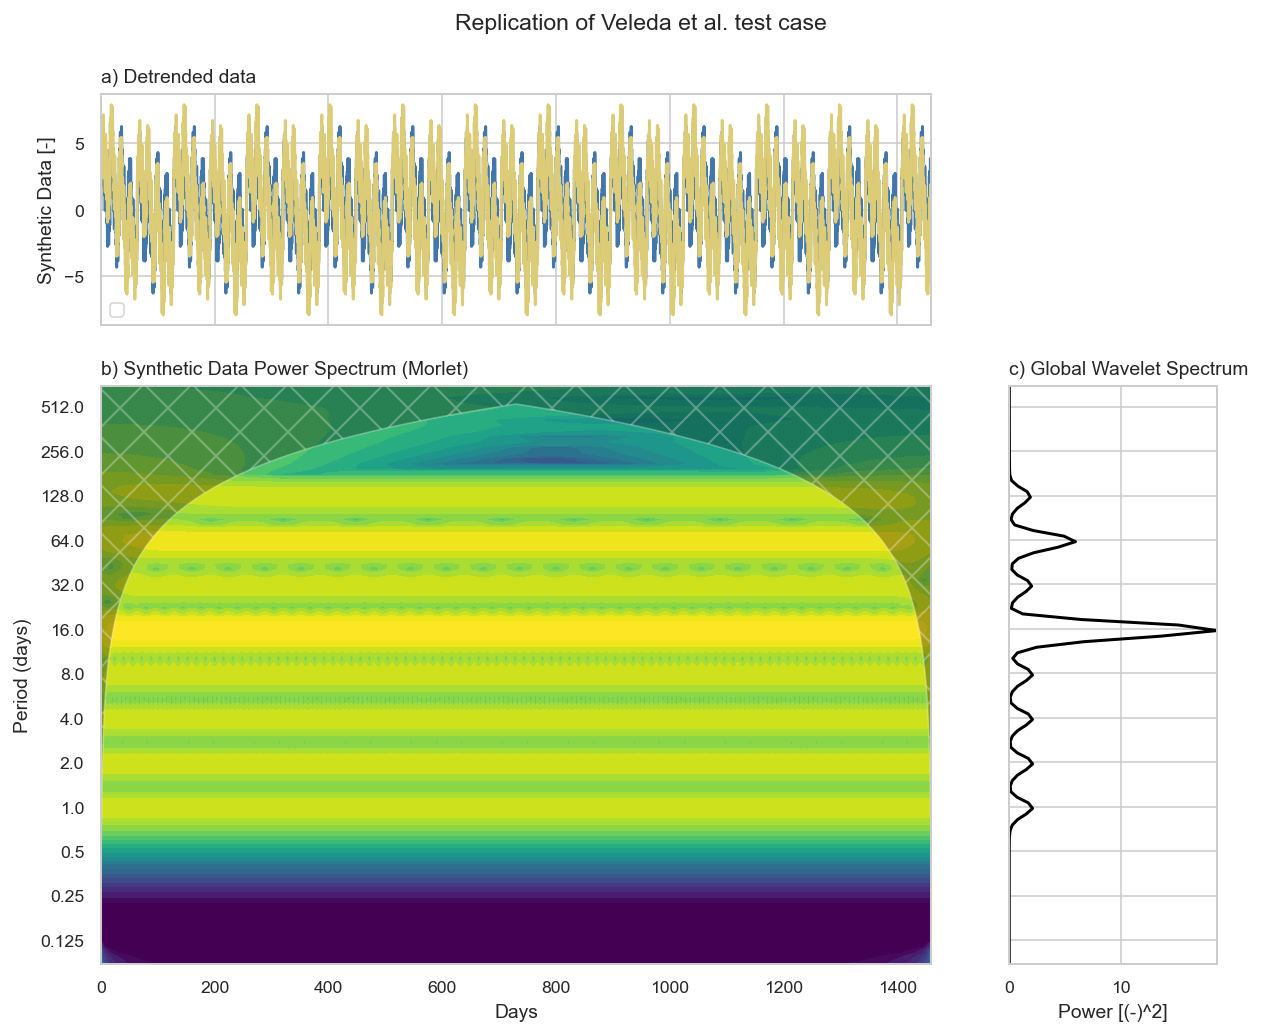

In [9]:
# Power is NOT squared since it is already the product of
# two wavelet spectra. Instead, we just take the absolute value
# of the complex values.

cwt_plt.plot_wv_power(
    signal_norm=[signal1, signal2],
    x=hours,
    dx=dx,
    period=period,
    power=np.abs(W12_corr),
    coi=coi,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False
)

As a side note I have confirmed that my version of the code and the pycwt code produce identical results when no rectification is provided (not shown).

### Comparison to test data

Top plot is without scale rectification and bottom plot is with scale rectification.

<img src='../figures/veleda2012_Fig3.png' width="600" height="600">

I cannot resolve the difference in magnitude between my and their global wavelet spectrum. As I have already demonstrated, there are unlabeled data transformations (i.e., log2). I don't know if they did something like further normalize or scale the power spectra. Regardless, I have sunk substantial time into trying to reconstruct it. For now, I can only document the difference, not explain it.

Note that the important features are similar: the one scale (16 days) at which both signals most strongly covary has a peak about an order magnitude larger than the other peaks. The peak with one signal oscilalting with a greater frequency is also mildly enhanced. The remaining peaks yield flat power across the scales. These are all desirable outcomes.

I followed the R package "biwavelet" which implements these scale rectifications. However, I opted to not scale the wavelet spectra by the largest wavelet scale. Otherwise, the code appears identical to me.

A post note: Ge 2007 documents a scaling present in the TC98 code that maintains the units but is typically not applied in applied mathematics literature, namely multiplying by the square root of the sampling period. As the sampling period is less than one, this has the possibility of explaining the very small values that V12 present.

# Wavelet Linear Coherence

This example should not yield a reasonable result.

No handles with labels found to put in legend.


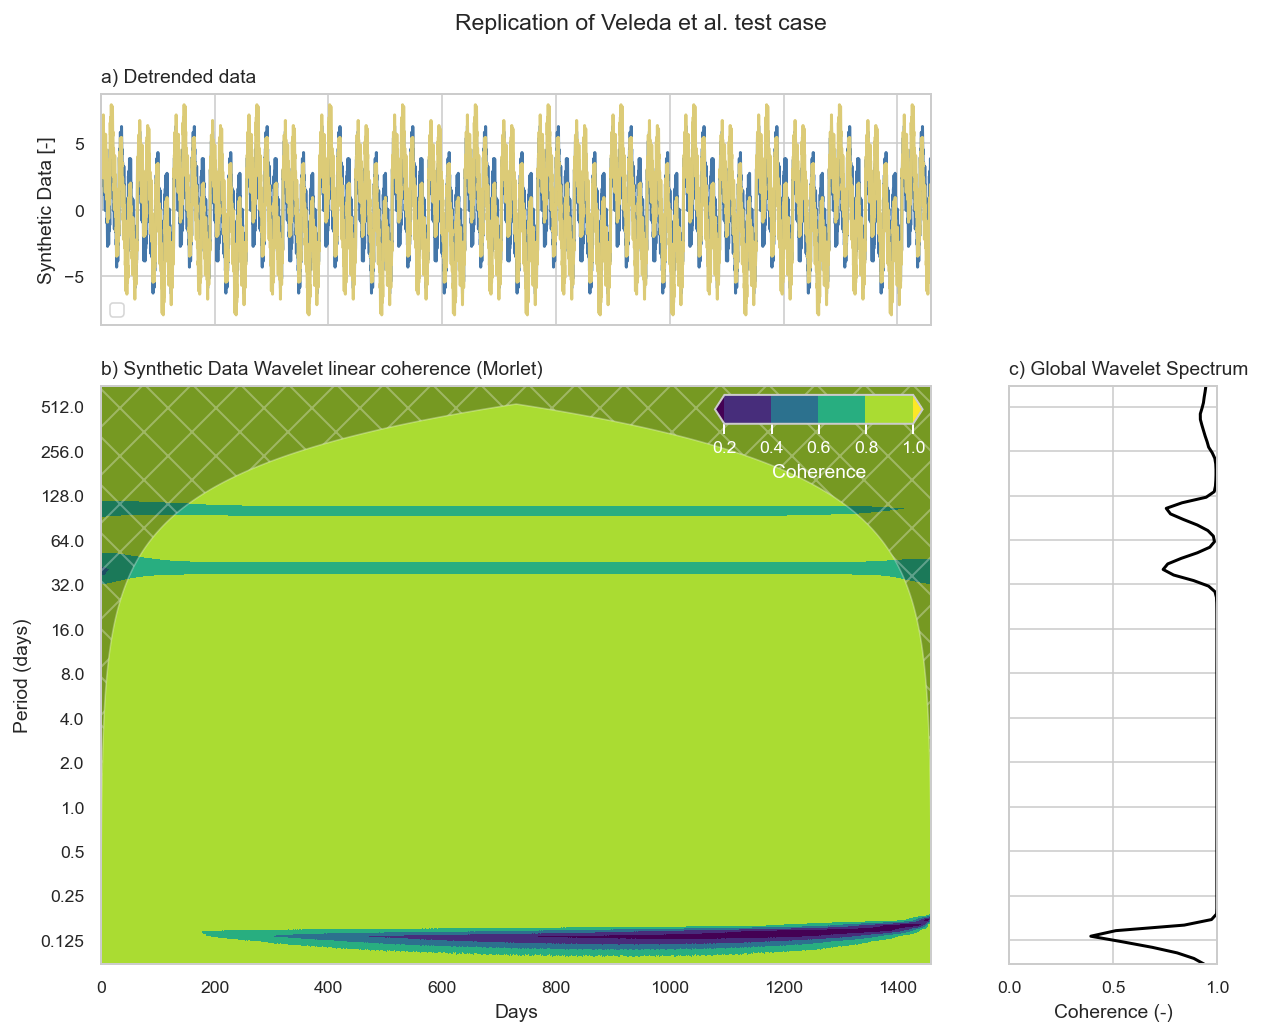

In [10]:
cwt_plt.plot_wv_power(
    signal_norm=[signal1, signal2],
    x=hours,
    dx=dx,
    period=period,
    power=WCT,
    coi=coi,
    fig_kwargs=None,
    fig_labels=fig_labels,
    levels=np.arange(0.2, 1.1, 0.2),
    include_colorbar=True,
    coherence=True,
    log_power=False,
)

As expected it does not return a reasonable result. Since the two signals are identical except for the amplitude the coherence is practically 1. I am a bit weirded out that the two signals with different amplitudes ended up with less coherence, even though they should co-vary identically.

### First, make sure coherence returns a value of 1 when given two identical signals

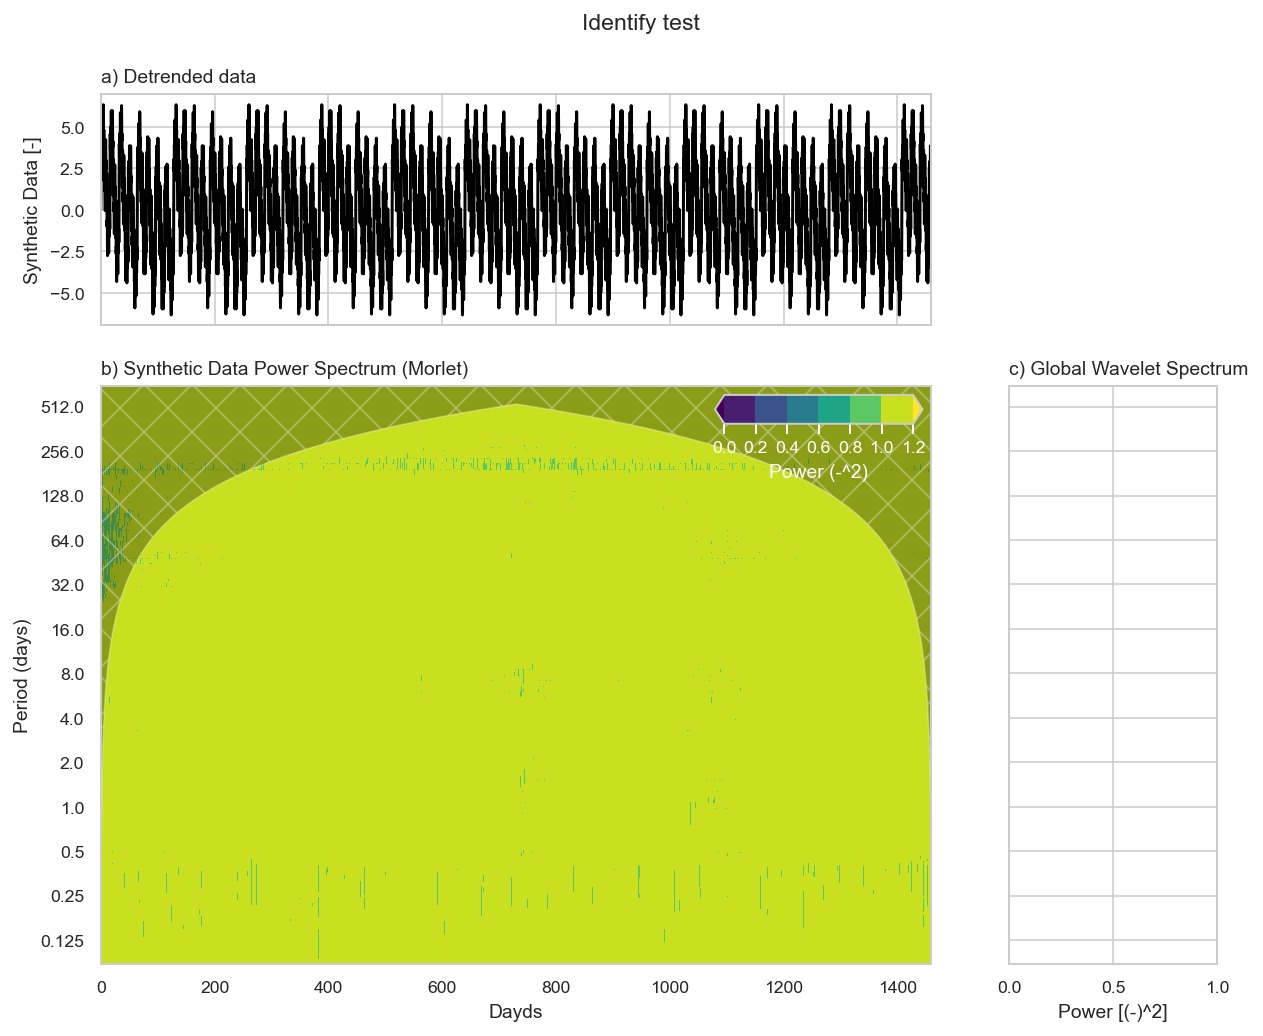

In [11]:
(WCT, aWCT, W12,
 W12_corr, period,
 coi, angle, s1, s2) = cwt_stat.wavelet_coherent(
    signal1, signal1, dx, octaves[0], 2 * dx, octaves[1], mother
)

fig_labels = {
    'title': 'Identify test',
    'label': 'Synthetic Data',
    'units': '-',
    'scale_units': 'days',
    'mother': mother.name,
    'avg_scales': 'None',
    'xlabel': 'Dayds'
}

cwt_plt.plot_wv_power(
    signal_norm=signal1,
    x=hours,
    dx=dx,
    period=period,
    power=WCT,
    coi=coi,
    levels=np.arange(0, 1.3, 0.2),
    log_power=False,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=True
)

To better show that the identify test functions as expected here is just the global power.

Text(0.5, 0, 'Period (days)')

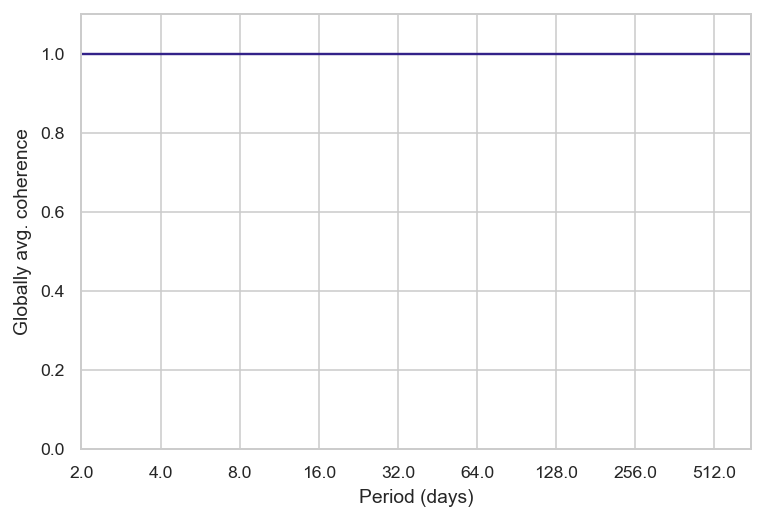

In [12]:
plt.plot(np.log2(period), np.mean(WCT, axis=1))
ax = plt.gca()
ax.set_ylim(0, 1.1)

Yticks = 2 ** np.arange(
    np.ceil(np.log2(period.min())),
    np.ceil(np.log2(period.max())))

ax.set_xticks(np.log2(Yticks))
ax.set_xticklabels(Yticks)
plt.setp(ax.get_xticklabels(), visible=True)
ax.set_xlim(np.log2([2, period.max()]))
ax.set_ylabel('Globally avg. coherence')
ax.set_xlabel('Period (days)')

WCT = 1 at all scales, as desired.

### Now test with some noise instead

No handles with labels found to put in legend.


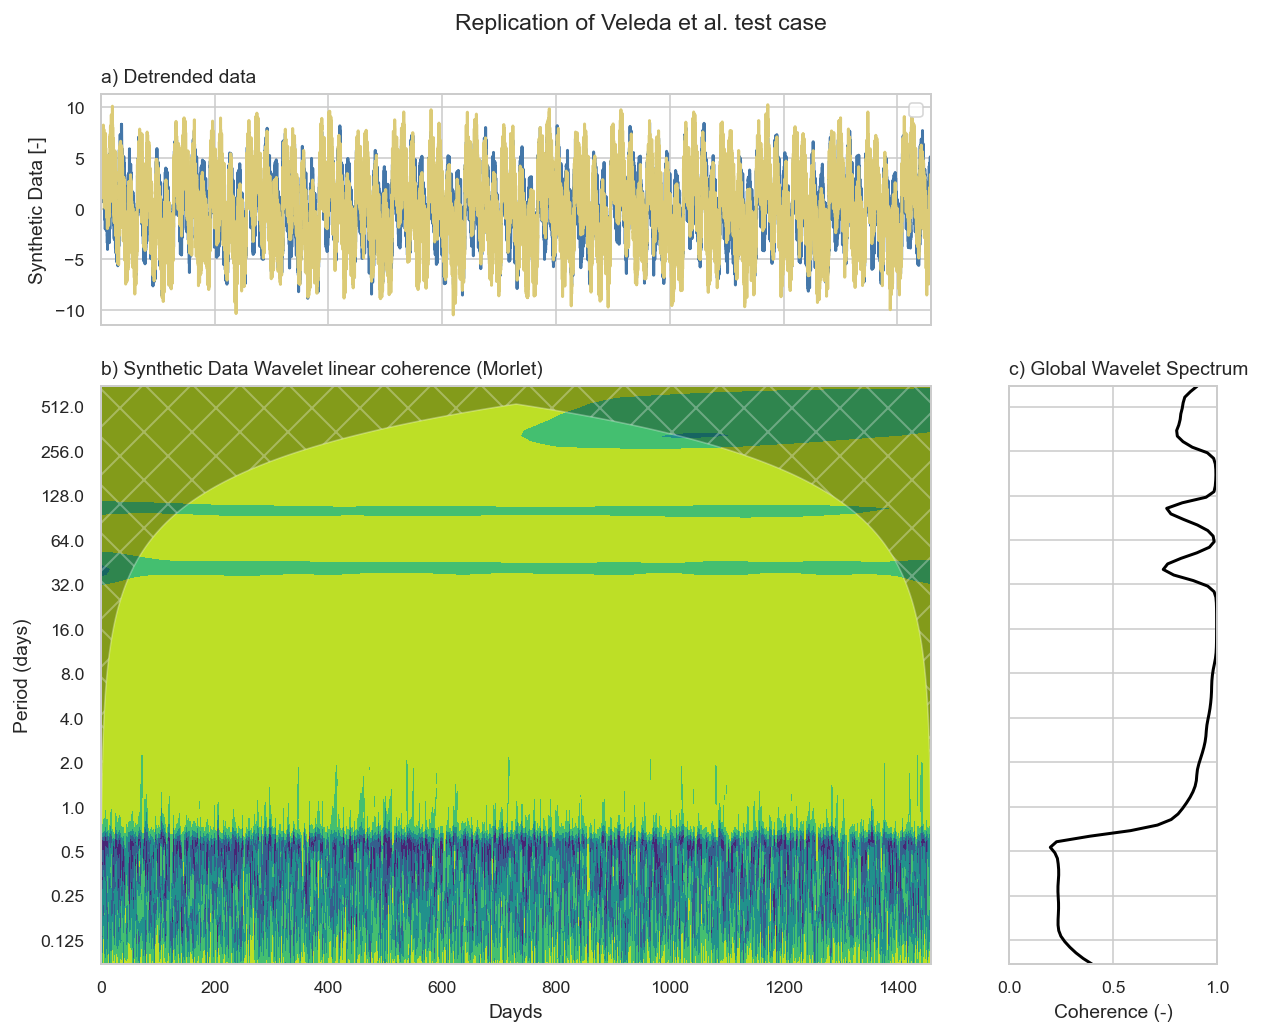

In [13]:
signal1 = signal1 + 1 * np.random.normal(0, 1, size=len(signal2))
signal2 = signal2 + 1 * np.random.normal(0, 1, size=len(signal2))

(WCT, aWCT, W12,
 W12_corr, period,
 coi, angle, s1, s2) = cwt_stat.wavelet_coherent(signal1, signal2, dx, octaves[0], 2 * dx, octaves[1], mother)

fig_labels = {
    'title': 'Replication of Veleda et al. test case',
    'label': 'Synthetic Data',
    'units': '-',
    'scale_units': 'days',
    'mother': mother.name,
    'avg_scales': 'None',
    'xlabel': 'Dayds'
}

cwt_plt.plot_wv_power(
    signal_norm=[signal1, signal2],
    x=hours,
    dx=dx,
    period=period,
    power=WCT,
    coi=coi,
    levels=np.arange(0, 1.1, 0.2),
    log_power=False,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False,
    coherence=True,
    )

Here we can see the effects of scale smoothing. The white noise is smoothed into the shorter time scales but the longer time scales are left mostly unaltered. This is precisely what I believe we should expect.

Note, I have verified that my helper function and the pycwt function produce identical wavelet coherency for this test case (not shown).

### Reproduce the matlab examples

Next, do this following the matlab example, which has time varying frequencies. This gives a better test for verifying the behavior of the pycwt functions.

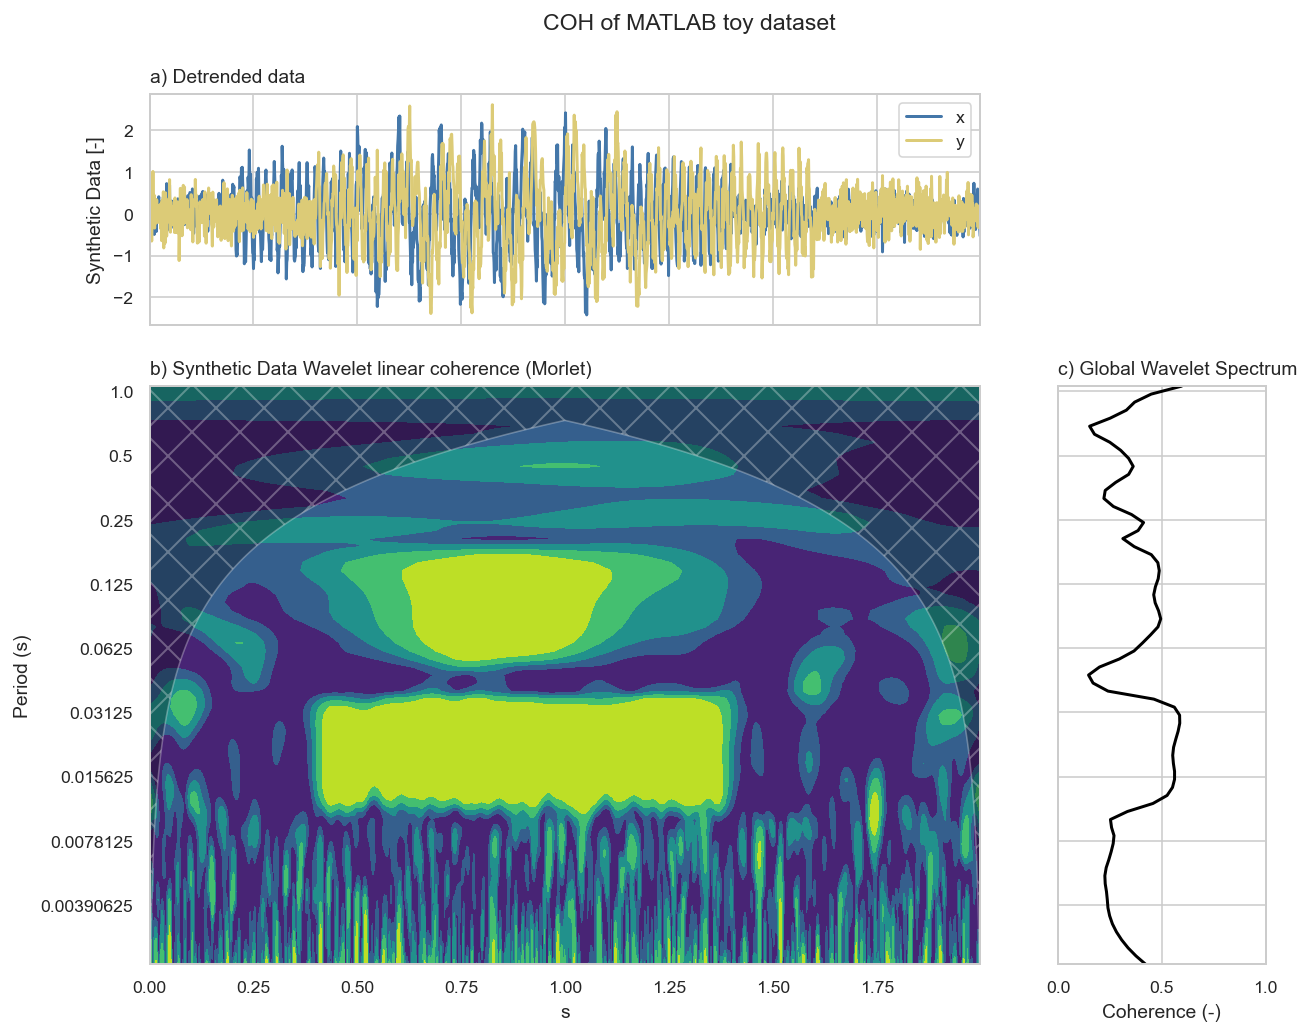

In [14]:
# Build the synthetic data
dt = 0.001
t = np.arange(0, 2, dt)
x = (
    np.cos(2 * np.pi * 10 * t) * ((t >= 0.5) & (t < 1.1))
    + np.cos(2 * np.pi * 50 * t) * ((t >= 0.2) & (t < 1.4))
    + 0.25 * np.random.normal(0, 1, size=len(t))
)
y = (
    np.sin(2 * np.pi * 10 * t) * ((t >= 0.6) & (t < 1.2))
    + np.sin(2 * np.pi * 50 * t) * ((t >= 0.4) & (t < 1.6))
    + 0.35 * np.random.normal(0, 1, size=len(t))
)

# Perform the WCT/XWT
octaves = [1 / 8, 9 / (1 / 8)]  

(WCT, aWCT, W12,
 W12_corr, period,
 coi, angle, s1, s2) = cwt_stat.wavelet_coherent(
    x, y, 0.001, octaves[0], 2 * 0.001, octaves[1], mother
)

fig_labels = {
    'title': 'COH of MATLAB toy dataset',
    'label': 'Synthetic Data',
    'units': '-',
    'scale_units': 's',
    'mother': mother.name,
    'avg_scales': 'None',
    'xlabel': 's',
    'signal_labels': ['x', 'y']
}

cwt_plt.plot_wv_power(
    signal_norm=[x, y],
    x=t,
    dx=dt,
    period=period,
    power=WCT,
    coi=coi,
    levels=np.arange(0, 1.1, 0.2),
    log_power=False,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False,
    coherence=True,
)

### Plotting side note:

You can build a periodogram without the subplots using the `plot_periodogram` helper function. See the below example.

Text(0.5, 0, 'Time (s)')

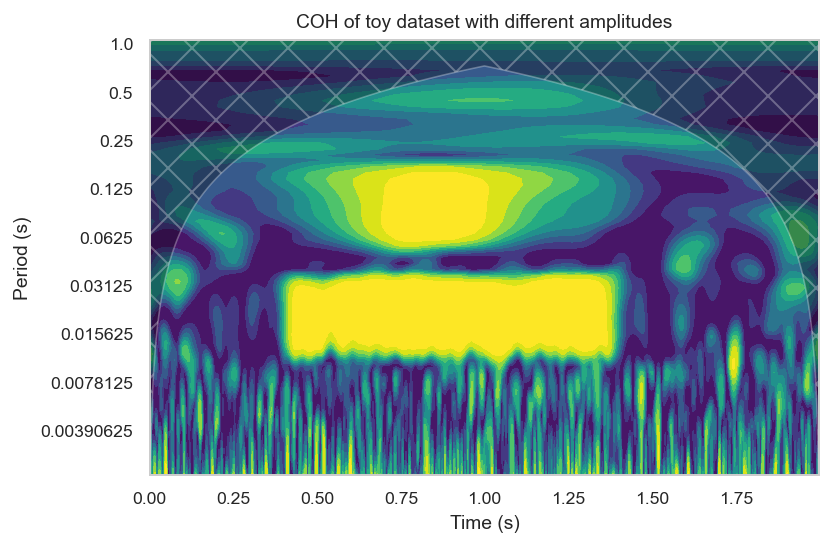

In [15]:
fig, ax = plt.subplots(1, 1,)
cwt_plt.plot_periodogram(
    WCT, t, dt, period, coi=coi, ax=ax, sig95=None, levels=np.arange(0, 1, 0.1), log_power=False
)
ax.set_title('COH of toy dataset with different amplitudes')
ax.set_ylabel('Period (s)')
ax.set_xlabel('Time (s)')

That behaves as expected (see https://www.mathworks.com/help/wavelet/ref/wcoherence.html)

One last remaining question is whether I need to normalize both time series if they have different e.g. amplitudes. One of the assumptions I can use when working with DTS is the knowledge that the underlying physical noise from the instrument is consistent from one bin to the next, even if the observations have different variances. Any differences in the data's standard deviation with LAF are therefore a function of changes in the underlying physical process. Varying the significance test e.g. for regions with enhanced submeso activity vs regions with suppressed submeso activity would potentially mask real changes in physics. In the context of FlyFOX results, within the SBL the relatively larger temperature perturbations are a result of a change in physics relative to the residual layer. The influence of these processes is something we wish to examine.

Here I run two tests:
1) One function has a smaller amplitude than the other (should I normalize?)

2) One function has a long-term non-stationarity that the other does not (e.g. comparing the SBL to residual layer, should I detrend?)

### 1) Role of normalizing

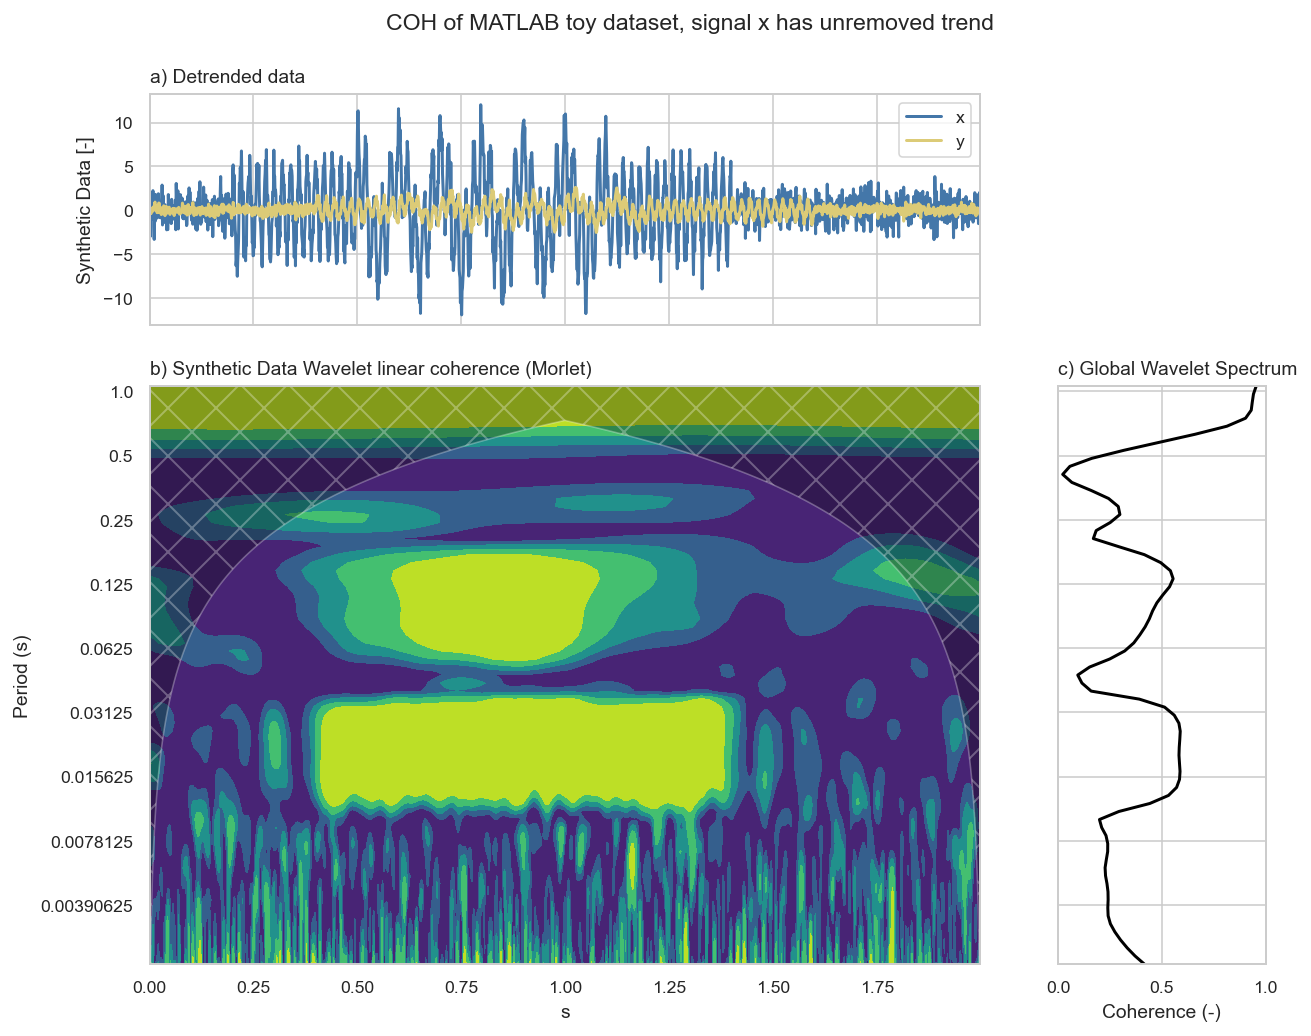

In [16]:
# Generate test data for case number 1.
t = np.arange(0, 2, 0.001)
x = (
    5 * (
        np.cos(2 * np.pi * 10 * t) * ((t >= 0.5) & (t < 1.1))
        + np.cos(2 * np.pi * 50 * t) * ((t >= 0.2) & (t < 1.4))
        + 0.25 * np.random.normal(0, 1, size=len(t))
    )
)
y = (
    np.sin(2 * np.pi * 10 * t) * ((t >= 0.6) & (t < 1.2))
    + np.sin(2 * np.pi * 50 * t) * ((t >= 0.4) & (t < 1.6))
    + 0.35 * np.random.normal(0, 1, size=len(t))
)

(WCT, aWCT, W12,
 W12_corr, period,
 coi, angle, s1, s2) = cwt_stat.wavelet_coherent(x, y, dt, octaves[0], 2 * dt, octaves[1], mother)

fig_labels = {
    'title': 'COH of MATLAB toy dataset, signal x has unremoved trend',
    'label': 'Synthetic Data',
    'units': '-',
    'scale_units': 's',
    'mother': mother.name,
    'avg_scales': 'None',
    'xlabel': 's',
    'signal_labels': ['x', 'y']
}

cwt_plt.plot_wv_power(
    signal_norm=[x, y],
    x=t,
    dx=dt,
    period=period,
    power=WCT,
    coi=coi,
    levels=np.arange(0, 1.1, 0.2),
    log_power=False,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False,
    coherence=True,
)

From a qualitative description, standardizing creates some small differences. That's good! And I think even expected, given that the definition of wavelet coherency actually normalizes by the standard deviation when following some of the substitutions (I belive eq 14 from TC98 compared to eq 24).

### 2) Trends in the data

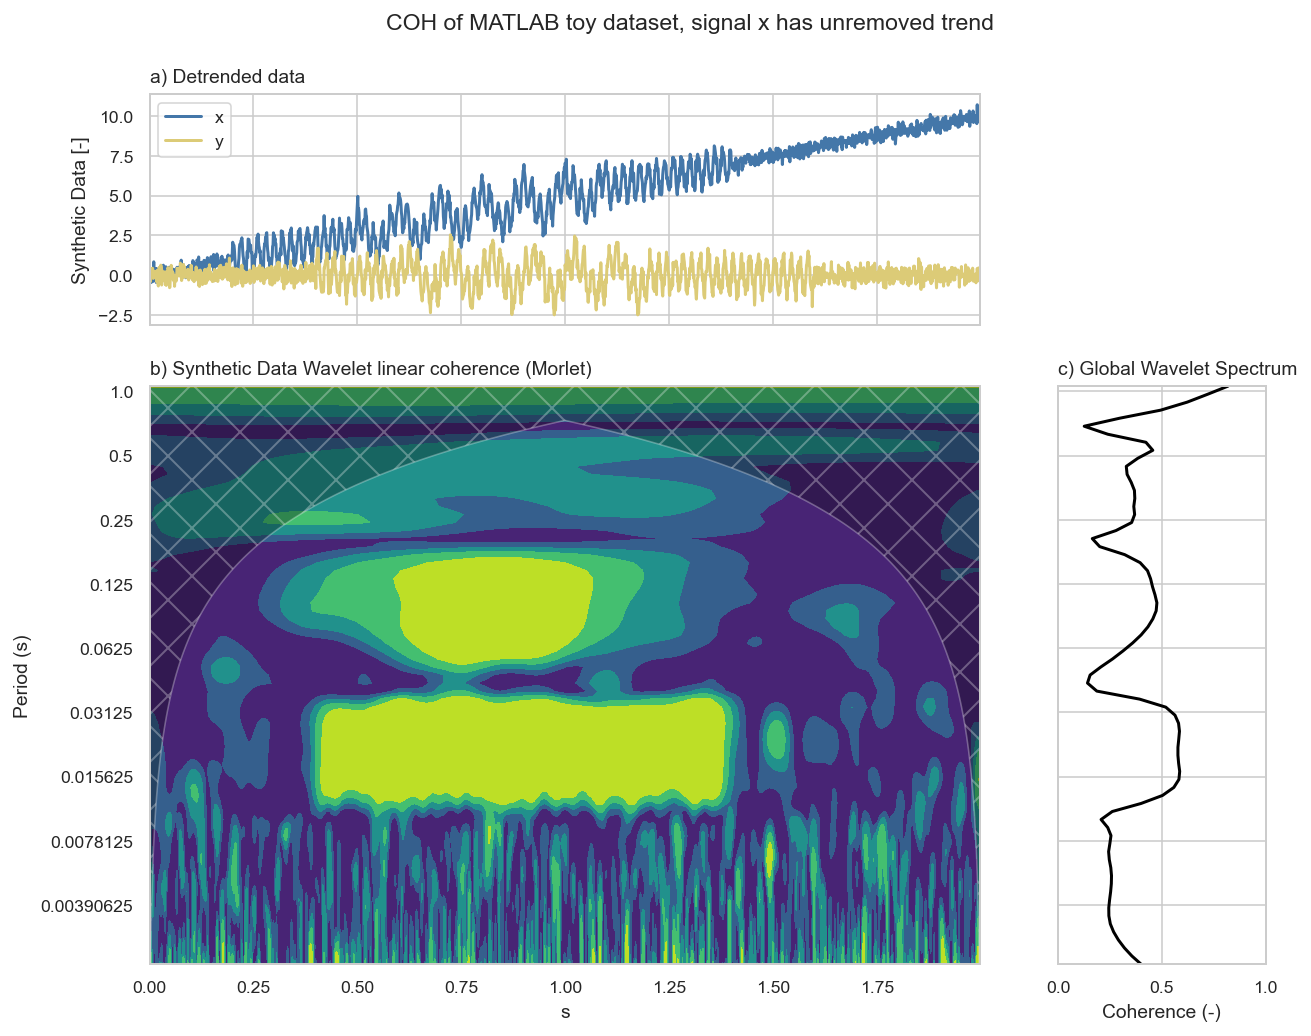

In [17]:
# Generate test data for case number 1.
t = np.arange(0, 2, dt)
x = (
    5 * t + (
        np.cos(2 * np.pi * 10 * t) * ((t >= 0.5) & (t < 1.1))
        + np.cos(2 * np.pi * 50 * t) * ((t >= 0.2) & (t < 1.4))
        + 0.25 * np.random.normal(0, 1, size=len(t))
    )
)
y = (
    np.sin(2 * np.pi * 10 * t) * ((t >= 0.6) & (t < 1.2))
    + np.sin(2 * np.pi * 50 * t) * ((t >= 0.4) & (t < 1.6))
    + 0.35 * np.random.normal(0, 1, size=len(t))
)


(WCT, aWCT, W12,
 W12_corr, period,
 coi, angle, s1, s2) = cwt_stat.wavelet_coherent(x, y, dt, octaves[0], 2 * dt, octaves[1], mother)

fig_labels = {
    'title': 'COH of MATLAB toy dataset, signal x has unremoved trend',
    'label': 'Synthetic Data',
    'units': '-',
    'scale_units': 's',
    'mother': mother.name,
    'avg_scales': 'None',
    'xlabel': 's',
    'signal_labels': ['x', 'y']
}

cwt_plt.plot_wv_power(
    signal_norm=[x, y],
    x=t,
    dx=dt,
    period=period,
    power=WCT,
    coi=coi,
    levels=np.arange(0, 1.1, 0.2),
    log_power=False,
    fig_kwargs=None,
    fig_labels=fig_labels,
    include_colorbar=False,
    coherence=True,
)

Here there are some qualitative changes in the shorter, more relavant time scales for the analysis. The longer time scales actually become more representative as the melange of coherence above the largest time scales in the synthetic dataset are diminished. Weird! But, I guess the answer is to detrend when obvious trends are present.